In [1]:
import stim

In [2]:
#Estimate logical error rate us stim
import stim
import pymatching
import numpy as np

def logical_errors_rate(circuit: stim.Circuit, num_shots: int) -> float:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors/num_shots



#circuit = stim.Circuit.generated("repetition_code:memory", rounds=100, distance=9, before_round_data_depolarization=0.03)
#%num_shots = 100_000
#num_logical_errors = count_logical_errors(circuit, num_shots)
#print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")



circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=100,
    distance=9,
    before_round_data_depolarization=0.13,
    before_measure_flip_probability=0.01)




num_shots = 100
logical_errors_rate = logical_errors_rate(circuit, num_shots)

In [3]:
num_logical_errors

0.17

Shots = 10, Logical Error Rate = 0.20000
Shots = 50, Logical Error Rate = 0.14000
Shots = 100, Logical Error Rate = 0.11000
Shots = 500, Logical Error Rate = 0.09600
Shots = 1000, Logical Error Rate = 0.08200
Shots = 1500, Logical Error Rate = 0.09200
Shots = 2000, Logical Error Rate = 0.09100
Shots = 2500, Logical Error Rate = 0.09080
Shots = 20000, Logical Error Rate = 0.08810
Shots = 40000, Logical Error Rate = 0.08972
Shots = 60000, Logical Error Rate = 0.09035


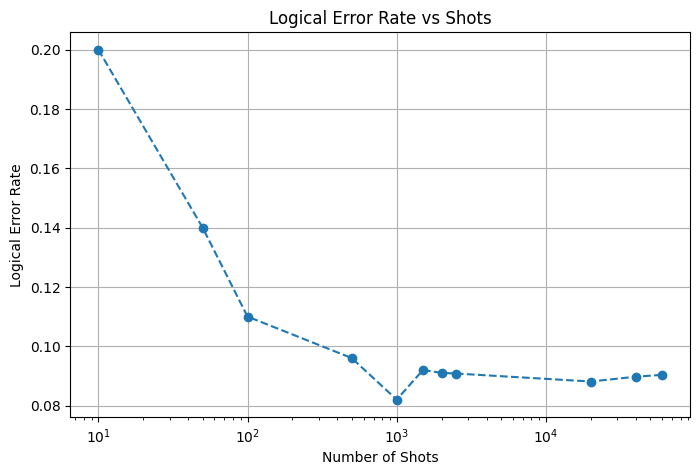

In [7]:
import stim
import pymatching
import numpy as np
import matplotlib.pyplot as plt

def logical_errors_rate(circuit: stim.Circuit, num_shots: int) -> float:
    """Returns the fraction of shots that produce a logical error."""
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(
        shots=num_shots,
        separate_observables=True
    )

    # Build a decoder (pymatching) from the circuit's detector error model.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Decode detection events to predict which observables flipped.
    predictions = matcher.decode_batch(detection_events)

    # Compare predicted flips to actual flips to count logical errors.
    num_errors = 0
    for shot_idx in range(num_shots):
        actual = observable_flips[shot_idx]
        predicted = predictions[shot_idx]
        if not np.array_equal(actual, predicted):
            num_errors += 1

    return num_errors / num_shots

# Example circuit. Adjust parameters to your needs.
#circuit = stim.Circuit.generated(
#    "repetition_code:memory",
#    rounds=100,
#    distance=25,
#    before_round_data_depolarization=0.13,
#    before_measure_flip_probability=0.01
#)

#circuit = stim.Circuit.generated(
#    "surface_code:rotated_memory_z",
#    rounds=5,
#    distance=5,
#    after_clifford_depolarization=0.005,
#    after_reset_flip_probability=0.005,
#    before_measure_flip_probability=0.005,
#    before_round_data_depolarization=0.005
#)


circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=5,
    distance=5,
    before_round_data_depolarization=0.1,
    before_measure_flip_probability=0.1
)


# Define a range of shot values you want to test.
shot_values = [10, 50, 100, 500,1000,1500,2000,2500,20000,40000,60000]

# Calculate the logical error rate for each shot value.
error_rates = []
for shots in shot_values:
    rate = logical_errors_rate(circuit, shots)
    error_rates.append(rate)
    print(f"Shots = {shots}, Logical Error Rate = {rate:.5f}")

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(shot_values, error_rates, marker='o', linestyle='--')
plt.xscale('log')  # Log scale often makes sense over wide shot ranges
plt.xlabel('Number of Shots')
plt.ylabel('Logical Error Rate')
plt.title('Logical Error Rate vs Shots')
plt.grid(True)
plt.savefig("rep5.png")
plt.show()

In [4]:
import stim
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=1,
    distance=3,
    before_round_data_depolarization=0.1,
    before_measure_flip_probability=0.1
)

In [6]:
circuit

stim.Circuit('''
    R 0 1 2 3 4
    TICK
    DEPOLARIZE1(0.1) 0 2 4
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    X_ERROR(0.1) 1 3
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    X_ERROR(0.1) 0 2 4
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')

In [1]:
import stim
import numpy as np
import pymatching
import math


oneQGate_ = ["H", "P", "X", "Y", "Z"]
oneQGateindices={"H":0, "P":1, "X":2, "Y":3, "Z":4}


twoQGate_ = ["CNOT", "CZ"]
twoQGateindices={"CNOT":0, "CZ":1}

pauliNoise_ = ["I","X", "Y", "Z"]
pauliNoiseindices={"I":0,"X":1, "Y":2, "Z":3}


class SingeQGate:
    def __init__(self, gateindex, qubitindex):
        self._name = oneQGate_[gateindex]
        self._qubitindex = qubitindex

    def __str__(self):
        return self._name + "[" + str(self._qubitindex) + "]"


class TwoQGate:
    def __init__(self, gateindex, control, target):
        self._name = twoQGate_[gateindex]
        self._control = control
        self._target = target

    def __str__(self):
        return self._name + "[" + str(self._control) + "," + str(self._target)+ "]"


class pauliNoise:
    def __init__(self, noiseindex, qubitindex):
        self._name="n"+str(noiseindex)
        self._noiseindex= noiseindex
        self._qubitindex = qubitindex
        self._noisetype=0


    def set_noisetype(self, noisetype):
        self._noisetype=noisetype


    def __str__(self):
        return self._name +"("+pauliNoise_[self._noisetype] +")" +"[" + str(self._qubitindex) + "]"


class Measurement:
    def __init__(self,measureindex ,qubitindex):
        self._name="M"+str(measureindex)
        self._qubitindex = qubitindex
        self._measureindex=measureindex

    def __str__(self):
        return self._name + "[" + str(self._qubitindex) + "]"


class Reset:
    def __init__(self, qubitindex):
        self._name="R"
        self._qubitindex = qubitindex

    def __str__(self):
        return self._name + "[" + str(self._qubitindex) + "]"



#Class: CliffordCircuit
class CliffordCircuit:


    def __init__(self, qubit_num):
        self._qubit_num = qubit_num
        self._totalnoise=0
        self._totalMeas=0
        self._totalgates=0
        self._gatelists=[]
        self._error_rate=0
        self._index_to_noise={}
        self._shownoise=False
        self._syndromeErrorTable={}
        #Store the repeat match group
        #For example, if we require M0=M1, M2=M3, then the match group is [[0,1],[2,3]]
        self._parityMatchGroup=[]
        self._stimcircuit=stim.Circuit()


    def set_error_rate(self, error_rate):
        self._error_rate=error_rate

    def get_stim_circuit(self):
        return self._stimcircuit

    def set_parityMatchGroup(self, parityMatchGroup):
        self._parityMatchGroup=parityMatchGroup

    def get_parityMatchGroup(self):
        return self._parityMatchGroup

    def get_qubit_num(self):
        return self._qubit_num
    
    def get_totalnoise(self):
        return self._totalnoise

    def get_totalMeas(self):
        return self._totalMeas

    '''
    Read the circuit from a file
    Example of the file:

    NumberOfQubit 6
    cnot 1 2
    cnot 1 3
    cnot 1 0
    M 0
    cnot 1 4
    cnot 2 4
    M 4
    cnot 2 5
    cnot 3 5
    M 5
    R 4
    R 5
    cnot 1 4
    cnot 2 4
    M 4
    cnot 2 5
    cnot 3 5
    M 5

    '''
    def read_circuit_from_file(self, filename):
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if not line:
                    continue  # Skip empty lines
                
                if line.startswith("NumberOfQubit"):
                    # Extract the number of qubits
                    self._qubit_num = int(line.split()[1])
                else:
                    # Parse the gate operation
                    parts = line.split()
                    gate_type = parts[0]
                    qubits = list(map(int, parts[1:]))
                    
                    if gate_type == "cnot":
                        self.add_cnot(qubits[0], qubits[1])
                    elif gate_type == "M":
                        self.add_measurement(qubits[0])
                    elif gate_type == "R":
                        self.add_reset(qubits[0])
                    elif gate_type == "H":
                        self.add_hadamard(qubits[0])
                    elif gate_type == "P":
                        self.add_phase(qubits[0])
                    elif gate_type == "CZ":
                        self.add_cz(qubits[0], qubits[1])
                    elif gate_type == "X":
                        self.add_paulix(qubits[0])
                    elif gate_type == "Y":
                        self.add_pauliy(qubits[0])
                    elif gate_type == "Z":
                        self.add_pauliz(qubits[0])
                    else:
                        raise ValueError(f"Unknown gate type: {gate_type}")

    
    def save_circuit_to_file(self, filename):
        pass



    def set_noise_type(self, noiseindex, noisetype):
        self._index_to_noise[noiseindex].set_noisetype(noisetype)


    def reset_noise_type(self):
        for i in range(self._totalnoise):
            self._index_to_noise[i].set_noisetype(0)

    def show_all_noise(self):
        for i in range(self._totalnoise):
            print(self._index_to_noise[i])


    def add_cnot(self, control, target):
        self._stimcircuit.append("X_ERROR", [control], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [control], self._error_rate)
        self._gatelists.append(pauliNoise(self._totalnoise, control))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1
        self._gatelists.append(pauliNoise(self._totalnoise, target))
        self._stimcircuit.append("X_ERROR", [target], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [target], self._error_rate)
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1
        self._gatelists.append(TwoQGate(twoQGateindices["CNOT"], control, target))
        self._stimcircuit.append("CNOT", [control, target])


    def add_hadamard(self, qubit):
        self._stimcircuit.append("X_ERROR", [qubit], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [qubit], self._error_rate)
        self._gatelists.append(pauliNoise(self._totalnoise, qubit))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1        
        self._gatelists.append(SingeQGate(oneQGateindices["H"], qubit))
        self._stimcircuit.append("H", [qubit])

    def add_phase(self, qubit):
        self._stimcircuit.append("X_ERROR", [qubit], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [qubit], self._error_rate)
        self._gatelists.append(pauliNoise(self._totalnoise, qubit))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1      
        self._gatelists.append(SingeQGate(oneQGateindices["P"], qubit))
        self._stimcircuit.append("S", [qubit])

    def add_cz(self, qubit1, qubit2):
        self._gatelists.append(pauliNoise(self._totalnoise, qubit1))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1
        self._gatelists.append(pauliNoise(self._totalnoise, qubit1))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1
        self._gatelists.append(TwoQGate(twoQGateindices["CZ"], qubit1, qubit2))     


    def add_paulix(self, qubit):
        self._stimcircuit.append("X_ERROR", [qubit], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [qubit], self._error_rate)
        self._gatelists.append(pauliNoise(self._totalnoise, qubit))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1     
        self._gatelists.append(SingeQGate(oneQGateindices["X"], qubit))
        self._stimcircuit.append("X", [qubit])

    def add_pauliy(self, qubit):
        self._stimcircuit.append("X_ERROR", [qubit], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [qubit], self._error_rate)
        self._gatelists.append(pauliNoise(self._totalnoise, qubit))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1    
        self._gatelists.append(SingeQGate(oneQGateindices["Y"], qubit))
        self._stimcircuit.append("Y", [qubit])

    def add_pauliz(self, qubit):
        self._stimcircuit.append("X_ERROR", [qubit], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [qubit], self._error_rate)
        self._gatelists.append(pauliNoise(self._totalnoise, qubit))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1    
        self._gatelists.append(SingeQGate(oneQGateindices["Z"], qubit))
        self._stimcircuit.append("Z", [qubit])

    def add_measurement(self, qubit):
        self._stimcircuit.append("X_ERROR", [qubit], self._error_rate)
        self._stimcircuit.append("Z_ERROR", [qubit], self._error_rate)
        self._gatelists.append(pauliNoise(self._totalnoise, qubit))
        self._index_to_noise[self._totalnoise]=self._gatelists[-1]
        self._totalnoise+=1   
        self._gatelists.append(Measurement(self._totalMeas,qubit))
        self._stimcircuit.append("M", [qubit])
        self._stimcircuit.append("DETECTOR", [stim.target_rec(-1)])
        self._totalMeas+=1

    
    def add_reset(self, qubit):
        self._gatelists.append(Reset(qubit))
        self._stimcircuit.append("R", [qubit])

    def setShowNoise(self, show):
        self._shownoise=show

    def __str__(self):
        str=""
        for gate in self._gatelists:
            if isinstance(gate, pauliNoise) and not self._shownoise:
                continue
            str+=gate.__str__()+"\n"
        return str


    def get_yquant_latex(self):
        """
        Convert the circuit (stored in self._gatelists) into a yquant LaTeX string.
        This version simply prints each gate (or noise box) in the order they appear,
        without grouping or any fancy logic.
        """
        lines = []
        # Begin the yquant environment
        lines.append("\\begin{yquant}")
        lines.append("")
        
        # Declare qubits and classical bits.
        # Note: Literal braces in the LaTeX code are escaped by doubling them.
        lines.append("% -- Qubits and classical bits --")
        lines.append("qubit {{$\\ket{{q_{{\\idx}}}}$}} q[{}];".format(self._qubit_num))
        lines.append("cbit {{$c_{{\\idx}} = 0$}} c[{}];".format(self._totalMeas))
        lines.append("")
        lines.append("% -- Circuit Operations --")
        
        # Process each gate in the order they were added.
        for gate in self._gatelists:
            if isinstance(gate, pauliNoise):
                # Print the noise box only if noise output is enabled.
                if self._shownoise:
                    lines.append("[fill=red!80]")
                    # The following format string produces, e.g.,:
                    # "box {$n_{8}$} q[2];"
                    lines.append("box {{$n_{{{}}}$}} q[{}];".format(gate._noiseindex, gate._qubitindex))
            elif isinstance(gate, TwoQGate):
                # Two-qubit gate (e.g., CNOT or CZ).
                if gate._name == "CNOT":
                    # Note: yquant syntax for a CNOT is: cnot q[target] | q[control];
                    line = "cnot q[{}] | q[{}];".format(gate._target, gate._control)
                elif gate._name == "CZ":
                    line = "cz q[{}] | q[{}];".format(gate._target, gate._control)
                lines.append(line)
            elif isinstance(gate, SingeQGate):
                # Single-qubit gate.
                if gate._name == "H":
                    line = "h q[{}];".format(gate._qubitindex)

                lines.append(line)
            elif isinstance(gate, Measurement):
                # Measurement is output as three separate lines.
                lines.append("measure q[{}];".format(gate._qubitindex))
                lines.append("cnot c[{}] | q[{}];".format(gate._measureindex, gate._qubitindex))
                lines.append("discard q[{}];".format(gate._qubitindex))
            elif isinstance(gate, Reset):
                # Reset is output as an initialization command.
                lines.append("init {{$\\ket0$}} q[{}];".format(gate._qubitindex))
            else:
                continue
        
        lines.append("")
        lines.append("\\end{yquant}")
        
        return "\n".join(lines)




class QEPG:

    def __init__(self):
        pass


    def add_x_type_edge(self, a, b):
        pass


    def add_y_type_edge(self, a, b):
        pass


    def add_z_type_edge(self, a, b):
        pass


    def matrix(self):
        pass


import random

def sample_fixed_ones(N, k):
    """
    Returns a list of length N containing exactly k ones 
    (and N-k zeros), in a random order.
    """
    # Step 1: Create a list of k ones and N-k zeros
    arr = [1]*k + [0]*(N-k)
    
    # Step 2: Shuffle the list randomly
    random.shuffle(arr)
    
    return arr



    



#Trace the pauli frame according to the circuit
#The pauli tracer can propagate pauli error(To verify fault-tolerance) as well as evolve stabilizer(To verify semantic correctness)
class PauliTracer:
    def __init__(self, circuit:CliffordCircuit):
        self._inducedNoise=["I"]*circuit._qubit_num
        self._measuredError={}
        self._circuit=circuit
        self._dataqubits=[i for i in range(circuit._qubit_num)]
        self._syndromequbits=[]
        self._parityMatchGroup=circuit.get_parityMatchGroup()

        #Store the initial stabilizers
        self._initStabilizers=["Z"]*circuit._qubit_num
        self._phasefactor=1

        self._errorrate=circuit._error_rate
        self._stimcircuit=circuit.get_stim_circuit()


    def set_errorrate(self, errorrate):
        self._errorrate=errorrate


    def set_initStabilizers(self, initStabilizers,phasefactor=1):
        self._initStabilizers=initStabilizers
        self._phasefactor=phasefactor


    def get_parityMatchGroup(self):
        return self._parityMatchGroup


    def set_dataqubits(self, dataqubits):
        self._dataqubits=dataqubits
        for i in range(self._circuit._qubit_num):
            if i not in dataqubits:
                self._syndromequbits.append(i)  


    def get_dataqubits(self):
        return self._dataqubits


    def get_inducedNoise(self):
        return self._inducedNoise


    def get_measuredError(self):
        return self._measuredError


    def get_qubit_num(self):
        return self._circuit.get_qubit_num()
    
    def get_totalnoise(self):
        return self._circuit.get_totalnoise()

    def get_totalMeas(self):
        return self._circuit.get_totalMeas()


    def set_noise_type(self, noiseindex, noisetype):
        self._circuit.set_noise_type(noiseindex, noisetype)


    def reset(self):
        self._inducedNoise=["I"]*circuit._qubit_num 
        self._measuredError={}      
        self._circuit.reset_noise_type()


    def set_initial_inducedNoise(self, inducedNoise):
        self._inducedNoise=inducedNoise


    def print_inducedNoise(self):
        print(self._inducedNoise)

    def print_measuredError(self):
        for key in self._measuredError:
            print(key, self._measuredError[key],sep=", ")
        print("\n")


    #Propagate pauli noise by CNOT gate
    def prop_CNOT(self, control, target):
        pauliStr=self._inducedNoise[control]+self._inducedNoise[target]
        if pauliStr=="XI":
            self._inducedNoise[control]="X"
            self._inducedNoise[target]="X"
        elif pauliStr=="XX":
            self._inducedNoise[control]="X"
            self._inducedNoise[target]="I"   
        elif pauliStr=="IZ":         
            self._inducedNoise[control]="Z"
            self._inducedNoise[target]="Z"
        elif pauliStr=="ZZ":         
            self._inducedNoise[control]="I"
            self._inducedNoise[target]="Z"
        elif pauliStr=="IY":
            self._inducedNoise[control]="Z"
            self._inducedNoise[target]="Y"
        elif pauliStr=="YI":
            self._inducedNoise[control]="Y"
            self._inducedNoise[target]="X"
        elif pauliStr=="XY":
            self._inducedNoise[control]="Y"
            self._inducedNoise[target]="Z"
        elif pauliStr=="YX":
            self._inducedNoise[control]="Y"
            self._inducedNoise[target]="I"
        elif pauliStr=="XZ":
            self._inducedNoise[control]="Y"
            self._inducedNoise[target]="Y"
        elif pauliStr=="YZ":
            self._inducedNoise[control]="X"
            self._inducedNoise[target]="Y"
        elif pauliStr=="ZY":
            self._inducedNoise[control]="I"
            self._inducedNoise[target]="Y"        

    def evolve_CNOT(self, control, target):
        pass


    #Propagate pauli noise by CZ gate
    def prop_CZ(self, control, target):
        pass

    def evolve_CZ(self, control, target):
        pass


    #Propagate pauli noise by H gate
    def prop_H(self, qubit):
        if self._inducedNoise[qubit]=="X":
            self._inducedNoise[qubit]="Z"
        elif self._inducedNoise[qubit]=="Z":
            self._inducedNoise[qubit]="X"


    def evolve_H(self, qubit):
        pass


    #Propagate pauli noise by P gate
    def prop_P(self, qubit):
        if self._inducedNoise[qubit]=="X":
            self._inducedNoise[qubit]="Y"
        elif self._inducedNoise[qubit]=="Y":
            self._inducedNoise[qubit]="X"        


    def evolve_P(self, qubit):
        pass


    #Add new pauli X noise to the induced noise
    def append_X(self, qubit):
        if self._inducedNoise[qubit]=="I":
            self._inducedNoise[qubit]="X"
        elif self._inducedNoise[qubit]=="X":
            self._inducedNoise[qubit]="I"
        elif self._inducedNoise[qubit]=="Y":
            self._inducedNoise[qubit]="Z"
        elif self._inducedNoise[qubit]=="Z":
            self._inducedNoise[qubit]="Y"


    def evolve_X(self, qubit):
        pass


    #Add new pauli Y noise to the induced noise
    def append_Y(self,qubit):
        if self._inducedNoise[qubit]=="I":
            self._inducedNoise[qubit]="Y"
        elif self._inducedNoise[qubit]=="X":
            self._inducedNoise[qubit]="Z"
        elif self._inducedNoise[qubit]=="Y":
            self._inducedNoise[qubit]="I"
        elif self._inducedNoise[qubit]=="Z":
            self._inducedNoise[qubit]="X"


    def evolve_Y(self, qubit):
        pass


    #Add new pauli Z noise to the induced noise
    def append_Z(self,qubit):
        if self._inducedNoise[qubit]=="I":
            self._inducedNoise[qubit]="Z"
        elif self._inducedNoise[qubit]=="X":
            self._inducedNoise[qubit]="Y"
        elif self._inducedNoise[qubit]=="Y":
            self._inducedNoise[qubit]="X"
        elif self._inducedNoise[qubit]=="Z":
            self._inducedNoise[qubit]="I"


    def evolve_Z(self, qubit):
        pass

    def prop_all(self):
        for gate in self._circuit._gatelists:
            if isinstance(gate, SingeQGate):
                if gate._name=="H":
                    self.prop_H(gate._qubitindex)
                elif gate._name=="P":
                    self.prop_P(gate._qubitindex)
            elif isinstance(gate, TwoQGate):
                if gate._name=="CNOT":
                    self.prop_CNOT(gate._control, gate._target)
                elif gate._name=="CZ":
                    self.prop_CZ(gate._control, gate._target)
            elif isinstance(gate, pauliNoise):
                if gate._noisetype==1:
                    self.append_X(gate._qubitindex)
                elif gate._noisetype==2:
                    self.append_Y(gate._qubitindex)
                elif gate._noisetype==3:
                    self.append_Z(gate._qubitindex)               
            elif isinstance(gate,Reset):
                self._inducedNoise[gate._qubitindex]="I"
            elif isinstance(gate, Measurement):
                self._measuredError[gate._measureindex]=self._inducedNoise[gate._qubitindex]


    def get_stim_circuit(self):
        return self._stimcircuit


    def evolve_stabilizer(self):
        for gate in self._circuit._gatelists:
            if isinstance(gate, SingeQGate):
                if gate._name=="H":
                    self.evolve_H(gate._qubitindex)
                elif gate._name=="P":
                    self.evolve_P(gate._qubitindex)
            elif isinstance(gate, TwoQGate):
                if gate._name=="CNOT":
                    self.evolve_CNOT(gate._control, gate._target)
                elif gate._name=="CZ":
                    self.evolve_CZ(gate._control, gate._target)
            elif isinstance(gate, pauliNoise):
                if gate._noisetype==1:
                    self.evolve_X(gate._qubitindex)
                elif gate._noisetype==2:
                    self.evolve_Y(gate._qubitindex)
                elif gate._noisetype==3:
                    self.evolve_Z(gate._qubitindex)
            elif isinstance(gate,Reset):
                continue
            elif isinstance(gate, Measurement):
                continue






class NaiveSampler():
    def __init__(self, circuit:CliffordCircuit):
        self._qubit_num=circuit._qubit_num     
        self._circuit=circuit
        self._totalnoise=circuit.get_totalnoise()

        self._logical_error_rate=0

        self._dataqubits=None
        self._syndromequbits=None
        self._stimcircuit=None

        self._shots=10

    def set_shots(self, shots):
        self._shots=shots


    def calc_logical_error_rate(self):
        self._stimcircuit=self._circuit.get_stim_circuit()

        sampler = self._stimcircuit.compile_detector_sampler()
       
        detector_error_model = self._stimcircuit.detector_error_model(decompose_errors=True)

        num_errors = 0

        for i in range(self._shots):
            detection_events, observable_flips = sampler.sample(1, separate_observables=True)
            #detection_events, observable_flips = sampler.sample(self._shots, separate_observables=True)
            # Configure a decoder using the circuit.
            #print(detection_events)
            #print(observable_flips)
            
            
            matcher = pymatching.Matching.from_detector_error_model(detector_error_model)
            predictions = matcher.decode_batch(detection_events)
            #print(predictions)
    
        
            actual_for_shot = observable_flips[0]
            predicted_for_shot = predictions[0]
            if not np.array_equal(actual_for_shot, predicted_for_shot):
                num_errors += 1
        
        self._logical_error_rate=num_errors/self._shots

        return self._logical_error_rate


    




class WSampler():
    def __init__(self, circuit:CliffordCircuit):
        self._inducedNoise=["I"]*circuit._qubit_num
        self._measuredError={}
        self._qubit_num=circuit._qubit_num     
        self._circuit=circuit
        self._totalnoise=circuit.get_totalnoise()

        self._logical_error_distribution=[0]*self._totalnoise
        self._logical_error_rate=0

        self._tracer=PauliTracer(circuit)
        self._detection_events=[]
        self._observable_flips=[]
        self._dataqubits=None
        self._syndromequbits=None
        self._stimcircuit=None

        self._detector_error_model=None
        self._shots=10

    def set_shots(self, shots):
        self._shots=shots


    def set_dataqubits(self, dataqubits):
        self._tracer.set_dataqubits(dataqubits)
        self._dataqubits=dataqubits

    #Sample noise with weight K
    def sample_Xnoise(self,W):
        random_index=sample_fixed_ones(self._totalnoise,W)
        for i in range(self._totalnoise):
            if random_index[i]==1:
                self._tracer.set_noise_type(i, 1)


    #Propagate the error, and get sample result
    def calc_sample_result(self):
        self._tracer.prop_all()
        self._measuredError=self._tracer.get_measuredError()
        tmp_detection_events=[]
        for i in self._measuredError.keys():
            if self._measuredError[i]=="X" or self._measuredError[i]=="Y":
                tmp_detection_events.append(True)
            else:
                tmp_detection_events.append(False)

        #The parity of the observable
        #TODO: User specify the observable
        tmp_observable_flips=[]
        
        for i in range(self._qubit_num):
            if i in self._dataqubits:
                if self._tracer._inducedNoise[i]=="X" or self._tracer._inducedNoise[i]=="Y":
                    tmp_observable_flips.append(True)
                else:
                    tmp_observable_flips.append(False)
                break
        
        return [tmp_detection_events], [tmp_observable_flips]
         

    def construct_detector_model(self):
        self._stimcircuit=self._tracer.get_stim_circuit()

        self._stimcircuit.append("M", [self._dataqubits[0]], 0)
        self._stimcircuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)

        #print(self._stimcircuit)

        self._detector_error_model= self._stimcircuit.detector_error_model(decompose_errors=True)
       



    #Propagate the error, and return if there is a logical error
    def has_logical_error(self):
        # Configure a decoder using the circuit.
        detection_events, observable_flips=self.calc_sample_result()
        #print(detection_events)
        #print(observable_flips)

        matcher = pymatching.Matching.from_detector_error_model(self._detector_error_model)
        predictions = matcher.decode_batch(detection_events)

        if not np.array_equal(observable_flips[0],predictions[0]):
            return True 
        return False



    def reset(self):
        self._tracer.reset()


    def binomial_weight(self, W):
        p=self._tracer._errorrate
        N=self._totalnoise
        return math.comb(N, W) * (p**W) * ((1 - p)**(N - W))


    def calc_error_rate_with_fixed_weight(self, W):
        errorshots=0
        for i in range(self._shots):
            self.reset()
            self.sample_Xnoise(W)
            if self.has_logical_error():
                errorshots+=1
        self._logical_error_distribution[W]=errorshots/self._shots



    def calc_logical_error_rate(self):
        for i in range(self._totalnoise):
            self.calc_error_rate_with_fixed_weight(i)
            self._logical_error_rate+=self.binomial_weight(i)*self._logical_error_distribution[i]

        return self._logical_error_rate



rep_decoder={"01111":"IXI","00101":"IIX","01010":"XII"}


rep_paritygroup=[[0],[1,2],[3,4]]


steane_decoder={"000001":"XIIIIII","000010":"IXIIIII","000011":"IIXIIII","000100":"IIIXIII","000101":"IIIIXII","000110":"IIIIIXI","000111":"IIIIIIX",
                "001000":"ZIIIIII","010000":"IZIIIII","011000":"IIZIIII","100000":"IIIZIII","101000":"IIIIZII","110000":"IIIIIZI","111000":"IIIIIIZ"}


steane_logicalZ="ZZZZZZZ"
steane_stabilizers=["IIIXXXX","IXXIIXX","XIXIXIX","IIIZZZZ","IZZIIZZ","ZIZIZIZ"]

steane_paritygroup=[[0,1],[2,3],[4,5],[6,7],[8,9],[10,11]]



def filter_string(s, indices):
    return ''.join(s[i] for i in indices)


class OneFaultFTVerifier:

    def __init__(self,pauliTracer:PauliTracer):
        self._pauliTracer=pauliTracer
        self._totalnoise=pauliTracer.get_totalnoise()
        self._totalMeas=pauliTracer.get_totalMeas()
        self._finaltableX={}
        self._finaltableZ={}       
        self._syndromeErrorTable={}
        self._filterdsyndromeErrorTable={}
        self._dataqubits=pauliTracer.get_dataqubits()
        self._parityMatchGroup=pauliTracer.get_parityMatchGroup()


    def generate_table(self):
        for i in range(self._totalnoise):
            self._pauliTracer.reset()
            self._pauliTracer.set_noise_type(i, 1)
            self._pauliTracer.prop_all()
            self._finaltableX[i]=(self._pauliTracer.get_measuredError(), self._pauliTracer.get_inducedNoise())
        for i in range(self._totalnoise):
            self._pauliTracer.reset()
            self._pauliTracer.set_noise_type(i, 3)
            self._pauliTracer.prop_all()
            self._finaltableZ[i]=(self._pauliTracer.get_measuredError(), self._pauliTracer.get_inducedNoise())

    #Transform the table from a dictionary to with many values to a dictionary with two values, just syndrome and the inducde noise
    #Use a bit string of 0,1 to represent the syndrome and a bit string of X,Y,Z to represent the induced noise 
    def transform_table(self,measuredError,inducedNoise):
        table={}
        for i in range(self._totalMeas):
            if measuredError[i]=="X":
                table[i]=1
            elif measuredError[i]=="Y":
                table[i]=1
            else:
                table[i]=0
        inducedNoiseStr=""
        for i in range(self._pauliTracer.get_qubit_num()):  
            if i in self._dataqubits:
                inducedNoiseStr+=inducedNoise[i]
        table["inducedNoise"]=inducedNoiseStr
        return table

    
    def transform_table_unique(self):
        for i in range(self._totalnoise):
            tmptable=self.transform_table(self._finaltableX[i][0], self._finaltableX[i][1])
            syndromeString=""
            for j in range(self._totalMeas):
                syndromeString+=str(tmptable[j])

            self._syndromeErrorTable["n"+str(i)+":X"]=(syndromeString,tmptable["inducedNoise"])

            tmptable=self.transform_table(self._finaltableZ[i][0], self._finaltableZ[i][1])
            syndromeString=""
            for j in range(self._totalMeas):
                syndromeString+=str(tmptable[j])

            self._syndromeErrorTable["n"+str(i)+":Z"]=(syndromeString,tmptable["inducedNoise"])



    def print_unique_table(self):
        print("Unique table")

        for key in self._syndromeErrorTable:
            print(key+"   ", self._syndromeErrorTable[key][0]+"   ", self._syndromeErrorTable[key][1])

        print("\n") 




    def filter_string_by_parity(self, syndromeString):
        '''
        Filter the syndrome string according to the parity match group
        '''
        bitlist=[int(x) for x in syndromeString]
        for group in self._parityMatchGroup:
            parity = sum(bitlist[i] for i in group) % 2
            if parity == 1:
                return False
        return True


    '''
    Filter the table based on the parity match group
    '''
    def filter_table(self):
        for key in self._syndromeErrorTable:
            if self.filter_string_by_parity(self._syndromeErrorTable[key][0]):
                self._filterdsyndromeErrorTable[key]=self._syndromeErrorTable[key]


    def print_filter_table(self):
        print("Filtered table")

        for key in self._filterdsyndromeErrorTable:
            print(key, self._filterdsyndromeErrorTable[key][0], self._filterdsyndromeErrorTable[key][1])

        print("\n")


    def verify_fault_tolerance(self):
        for key in self._filterdsyndromeErrorTable:
            correction=rep_decoder[self._filterdsyndromeErrorTable[key][0]]
            error=self._filterdsyndromeErrorTable[key][1]
            if error!=correction:
                return False
        return True



    def print_table(self):
        print("X error table")
        for i in range(self._totalnoise):
            print("n"+str(i)+"=X", self.transform_table(self._finaltableX[i][0], self._finaltableX[i][1]))

        print("\nZ error table")
        for i in range(self._totalnoise):
            print("n"+str(i)+"=Z", self.transform_table(self._finaltableZ[i][0], self._finaltableZ[i][1]))

        print("\n")




class repetitionCode():


    def __init__(self, code_distance, error_rate):
        self._circuit=CliffordCircuit()






    

    


In [3]:
circuit=CliffordCircuit(2)
circuit.set_error_rate(0.001)
circuit.read_circuit_from_file("code/repetition")



tracer=PauliTracer(circuit) 
tracer.set_dataqubits([1,2,3])
sampler=WSampler(circuit)
sampler.set_shots(200)
sampler.set_dataqubits([1,2,3])
sampler.construct_detector_model()

sampler.calc_logical_error_rate()
print(sampler._logical_error_distribution)

print(sampler._logical_error_rate)


Nsampler=NaiveSampler(circuit)
Nsampler.set_shots(200)
Nsampler.calc_logical_error_rate()
print(Nsampler._logical_error_rate)

[0.0, 0.12, 0.395, 0.39, 0.435, 0.57, 0.485, 0.555, 0.485, 0.52, 0.46, 0.52, 0.5, 0.47, 0.555, 0.5, 0.48, 0.5, 0.525, 0.52, 0.46, 0.465, 0.525, 0.585, 0.635, 0.7, 0.695]
0.0032931459658744606
0.01


In [35]:
import matplotlib.pyplot as plt

sample_list=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,300,400,500,600,700,800,900,1000,1500,2000,2500,3000,3500,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]


Wlist=[]
Nlist=[]

for shot in sample_list:
    circuit=CliffordCircuit(2)
    circuit.set_error_rate(0.0001)
    circuit.read_circuit_from_file("code/repetition")
    
    
    tracer=PauliTracer(circuit) 
    tracer.set_dataqubits([1,2,3])
    sampler=WSampler(circuit)
    sampler.set_shots(shot)
    sampler.set_dataqubits([1,2,3])
    sampler.construct_detector_model()
    
    sampler.calc_logical_error_rate()

    print(sampler._logical_error_rate)
    Wlist.append(sampler._logical_error_rate)    
    
    Nsampler=NaiveSampler(circuit)
    Nsampler.set_shots(shot)
    Nsampler.calc_logical_error_rate()
    print(Nsampler._logical_error_rate)    

    Nlist.append(Nsampler._logical_error_rate)

0.000541049494559289
0.0
0.0002700007299348797
0.0
0.0001810508572215207
0.0
0.00020355146529615293
0.0
0.00032400058338754564
0.0
0.0004052332695391585
0.016666666666666666
0.0004630068200625367
0.0
0.00040504354633215313
0.0
0.0005397272920324574
0.011111111111111112
0.00037786015475056993
0.0
0.0004661725534692248
0.0
0.0003827921342876668
0.0
0.0004362075764640422
0.0
0.0004242604759021775
0.0
0.0003781401270352078
0.006666666666666667
0.0005228837970888571
0.0
0.00044499399582279285
0.0
0.00037525280199045334
0.0
0.00028452408663893043
0.0
0.0003512978822193509
0.0
0.0003473763144797241
0.0
0.00038054978155249253
0.004545454545454545
0.0004929821933810378
0.0
0.00032643988122827095
0.0
0.0003243269084631541
0.0
0.0004521972841175038
0.0
0.0004212768401778572
0.0
0.00042745316573489716
0.0
0.0004628217716232348
0.0014285714285714286
0.00042864230156582
0.0
0.000354217929085288
0.0011111111111111111
0.0004051749448462717
0.001
0.0004319974554137431
0.0006666666666666666
0.0004023664

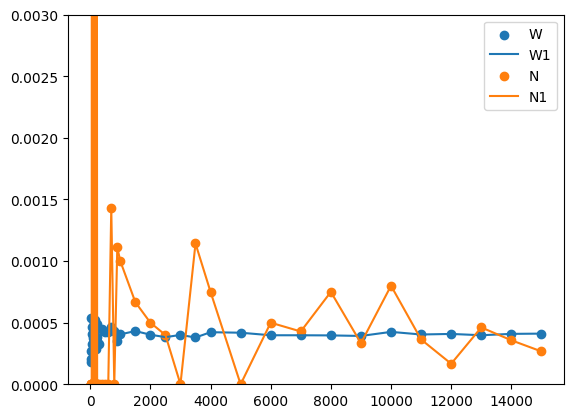

In [37]:
plt.scatter(sample_list,Wlist,label="W")
plt.plot(sample_list,Wlist,label="W1")
plt.scatter(sample_list,Nlist,label="N")
plt.plot(sample_list,Nlist,label="N1")
plt.ylim(0,0.003)
plt.legend()

In [38]:
import matplotlib.pyplot as plt

sample_list=[10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,28000,30000]


Wlist=[]
Nlist=[]

for shot in sample_list:
    circuit=CliffordCircuit(2)
    circuit.set_error_rate(0.0001)
    circuit.read_circuit_from_file("code/repetition")
    
    
    tracer=PauliTracer(circuit) 
    tracer.set_dataqubits([1,2,3])
    sampler=WSampler(circuit)
    sampler.set_shots(shot)
    sampler.set_dataqubits([1,2,3])
    sampler.construct_detector_model()
    
    sampler.calc_logical_error_rate()

    print(sampler._logical_error_rate)
    Wlist.append(sampler._logical_error_rate)    
    
    Nsampler=NaiveSampler(circuit)
    Nsampler.set_shots(shot)
    Nsampler.calc_logical_error_rate()
    print(Nsampler._logical_error_rate)    

    Nlist.append(Nsampler._logical_error_rate)

0.00040134278606773977
0.0002
0.00039652009975494484
0.00027272727272727274
0.0003925008825433631
0.0004166666666666667
0.00039283764494901655
0.0003846153846153846
0.00039895302199196593
0.0005714285714285715
0.00040023116845875326
6.666666666666667e-05
0.00039768630151357774
0.0005625
0.00040607310917320017
0.0005294117647058823
0.0004082411179424367
0.0002777777777777778
0.00040353790548961567
0.0004210526315789474
0.00040266059103221774
0.0004
0.0003903507658939476
0.0004761904761904762
0.00040484052468457227
0.0003181818181818182
0.00040241164262224685
0.0003043478260869565
0.00040148990091756304
0.0005416666666666666
0.0003903410393342749
0.00028
0.0003955738986711185
0.0005
0.00039656417682133494
0.0002666666666666667


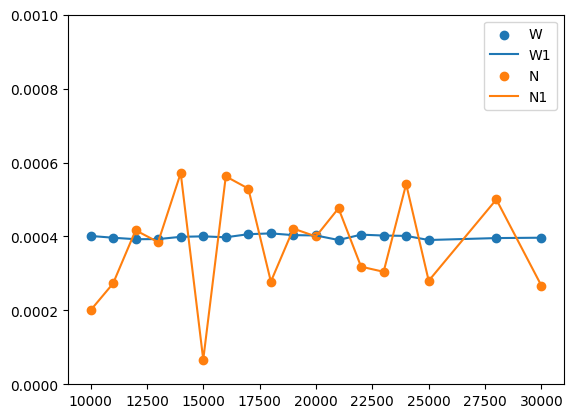

In [45]:
plt.scatter(sample_list,Wlist,label="W")
plt.plot(sample_list,Wlist,label="W1")
plt.scatter(sample_list,Nlist,label="N")
plt.plot(sample_list,Nlist,label="N1")
plt.ylim(0,0.001)
plt.legend()

In [66]:
import stim
circuit = stim.Circuit.generated("color_code:memory_xyz",rounds=2,distance=3).flattened()

In [67]:
print(circuit)

QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0.5, 1) 4
QUBIT_COORDS(1.5, 1) 5
QUBIT_COORDS(2.5, 1) 6
QUBIT_COORDS(1, 2) 7
QUBIT_COORDS(2, 2) 8
QUBIT_COORDS(1.5, 3) 9
R 0 1 2 3 4 5 6 7 8 9
TICK
C_XYZ 0 1 3 5 6 7 9
TICK
CX 5 4 3 2
TICK
CX 7 4 6 2
TICK
CX 1 4 6 8
TICK
CX 1 2 7 8
TICK
CX 5 2 9 8
TICK
CX 0 4 5 8
TICK
MR 2 4 8
TICK
C_XYZ 0 1 3 5 6 7 9
TICK
CX 5 4 3 2
TICK
CX 7 4 6 2
TICK
CX 1 4 6 8
TICK
CX 1 2 7 8
TICK
CX 5 2 9 8
TICK
CX 0 4 5 8
TICK
MR 2 4 8
DETECTOR(2, 0, 0) rec[-3] rec[-6]
DETECTOR(0.5, 1, 0) rec[-2] rec[-5]
DETECTOR(2, 2, 0) rec[-1] rec[-4]
MY 0 1 3 5 6 7 9
DETECTOR(2, 0, 1) rec[-3] rec[-4] rec[-5] rec[-6] rec[-10] rec[-13]
DETECTOR(0.5, 1, 1) rec[-2] rec[-4] rec[-6] rec[-7] rec[-9] rec[-12]
DETECTOR(2, 2, 1) rec[-1] rec[-2] rec[-3] rec[-4] rec[-8] rec[-11]
OBSERVABLE_INCLUDE(0) rec[-5] rec[-6] rec[-7]


In [68]:
def rewrite_stim_code(code: str) -> str:
    """
    Rewrites a Stim program so that each line contains at most one gate or measurement.
    Lines starting with TICK, R, DETECTOR(, and OBSERVABLE_INCLUDE( are kept as-is.
    Multi-target lines for CX, M, and MR are split up.
    """
    lines = code.splitlines()
    output_lines = []

    for line in lines:
        stripped_line = line.strip()
        if not stripped_line:
            # Skip empty lines (optional: you could also preserve them)
            continue

        # Keep lines that we do NOT want to split
        if (stripped_line.startswith("TICK") or
            stripped_line.startswith("DETECTOR(") or
            stripped_line.startswith("QUBIT_COORDS(") or     
            stripped_line.startswith("OBSERVABLE_INCLUDE(")):
            output_lines.append(stripped_line)
            continue

        tokens = stripped_line.split()
        gate = tokens[0]

        # Handle 2-qubit gate lines like "CX 0 1 2 3 4 5 ..."
        if gate == "CX":
            qubits = tokens[1:]
            # Pair up the qubits [q0, q1, q2, q3, ...] => (q0,q1), (q2,q3), ...
            for i in range(0, len(qubits), 2):
                q1, q2 = qubits[i], qubits[i + 1]
                output_lines.append(f"CX {q1} {q2}")

        # Handle multi-qubit measurements "M 1 3 5 ..." => each on its own line
        elif gate == "M":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"M {q}")


        elif gate == "MX":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"H {q}")
                output_lines.append(f"M {q}")

        elif gate == "MY":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"S {q}")
                output_lines.append(f"S {q}")
                output_lines.append(f"S {q}")
                output_lines.append(f"H {q}")                
                output_lines.append(f"M {q}")



        elif gate == "H":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"H {q}")

        elif gate == "S":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"S {q}")            

        # Handle multi-qubit measure+reset "MR 1 3 5 ..." => each on its own line
        elif gate == "MR":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"M {q}")
                output_lines.append(f"R {q}")

        elif gate == "R":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"R {q}")
        
        elif gate == "RX":
            qubits = tokens[1:]
            for q in qubits:
                output_lines.append(f"R {q}")
                output_lines.append(f"H {q}")                


        else:
            # If there's some other gate we don't specifically handle,
            # keep it as is, or add more logic if needed.
            output_lines.append(stripped_line)

    return "\n".join(output_lines)


def insert_noise_for_h_cx(code: str, p: float) -> str:
    """
    Inserts X_ERROR(p) and Z_ERROR(p) lines immediately before each H or CX line.

    For example:
      H 0
    becomes:
      X_ERROR(p) 0
      Z_ERROR(p) 0
      H 0

    and:
      CX 0 1
    becomes:
      X_ERROR(p) 0
      Z_ERROR(p) 0
      X_ERROR(p) 1
      Z_ERROR(p) 1
      CX 0 1

    Args:
        code: A string containing Stim code, where gates have already been split 
              into single-target (H) or single-pair (CX) lines.
        p: The probability for X_ERROR and Z_ERROR insertions.

    Returns:
        A modified Stim program (string) with inserted noise lines.
    """
    lines = code.splitlines()
    new_lines = []

    for line in lines:
        stripped_line = line.strip()
        if not stripped_line:
            # Skip or preserve empty lines as desired
            new_lines.append(line)
            continue

        tokens = stripped_line.split()
        gate = tokens[0]

        # If it's H gate with one qubit, insert noise lines
        if gate == "H" and len(tokens) == 2:
            qubit = tokens[1]
            new_lines.append(f"X_ERROR({p}) {qubit}")
            new_lines.append(f"Z_ERROR({p}) {qubit}")
            new_lines.append(stripped_line)

        # If it's CX gate with two qubits, insert noise lines
        elif gate == "CX" and len(tokens) == 3:
            cqubit = tokens[1]
            tqubit = tokens[2]
            new_lines.append(f"X_ERROR({p}) {cqubit}")
            new_lines.append(f"Z_ERROR({p}) {cqubit}")
            new_lines.append(f"X_ERROR({p}) {tqubit}")
            new_lines.append(f"Z_ERROR({p}) {tqubit}")
            new_lines.append(stripped_line)

        else:
            # Otherwise, keep the line as is
            new_lines.append(stripped_line)

    return "\n".join(new_lines)

In [69]:
newstr=rewrite_stim_code(str(circuit))

In [70]:
print(newstr)

QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0.5, 1) 4
QUBIT_COORDS(1.5, 1) 5
QUBIT_COORDS(2.5, 1) 6
QUBIT_COORDS(1, 2) 7
QUBIT_COORDS(2, 2) 8
QUBIT_COORDS(1.5, 3) 9
R 0
R 1
R 2
R 3
R 4
R 5
R 6
R 7
R 8
R 9
TICK
C_XYZ 0 1 3 5 6 7 9
TICK
CX 5 4
CX 3 2
TICK
CX 7 4
CX 6 2
TICK
CX 1 4
CX 6 8
TICK
CX 1 2
CX 7 8
TICK
CX 5 2
CX 9 8
TICK
CX 0 4
CX 5 8
TICK
M 2
R 2
M 4
R 4
M 8
R 8
TICK
C_XYZ 0 1 3 5 6 7 9
TICK
CX 5 4
CX 3 2
TICK
CX 7 4
CX 6 2
TICK
CX 1 4
CX 6 8
TICK
CX 1 2
CX 7 8
TICK
CX 5 2
CX 9 8
TICK
CX 0 4
CX 5 8
TICK
M 2
R 2
M 4
R 4
M 8
R 8
DETECTOR(2, 0, 0) rec[-3] rec[-6]
DETECTOR(0.5, 1, 0) rec[-2] rec[-5]
DETECTOR(2, 2, 0) rec[-1] rec[-4]
S 0
S 0
S 0
H 0
M 0
S 1
S 1
S 1
H 1
M 1
S 3
S 3
S 3
H 3
M 3
S 5
S 5
S 5
H 5
M 5
S 6
S 6
S 6
H 6
M 6
S 7
S 7
S 7
H 7
M 7
S 9
S 9
S 9
H 9
M 9
DETECTOR(2, 0, 1) rec[-3] rec[-4] rec[-5] rec[-6] rec[-10] rec[-13]
DETECTOR(0.5, 1, 1) rec[-2] rec[-4] rec[-6] rec[-7] rec[-9] rec[-12]
DETECTOR(2, 2, 1) rec[-1]

In [37]:
circ=stim.Circuit(stim_program_text=newstr)

In [77]:
def compile_from_stim_circuit_str(stim_str):
    lines = stim_str.splitlines()
    output_lines = []
    
    '''
    First, read and compute the parity match group and the observable
    '''
    parityMatchGroup=[]
    observable=[]

    
    measure_index_to_line={}
    measure_line_to_measure_index={}        
    current_line_index=0
    current_measure_index=0
    for line in lines:
        stripped_line = line.strip()
        if not stripped_line:
            # Skip empty lines (optional: you could also preserve them)
            current_line_index+=1
            continue
        
        # Keep lines that we do NOT want to split
        if (stripped_line.startswith("TICK") or
            stripped_line.startswith("DETECTOR(") or
            stripped_line.startswith("OBSERVABLE_INCLUDE(")):
            current_line_index+=1
            continue

        tokens = stripped_line.split()
        gate = tokens[0]

        if gate == "M":
            measure_index_to_line[current_measure_index]=current_line_index
            measure_line_to_measure_index[current_line_index]=current_measure_index
            current_measure_index+=1

        current_line_index+=1


    print(measure_index_to_line)
    print(measure_line_to_measure_index)
    
    
    current_line_index=0
    measure_stack=[]
    
    for line in lines:
        stripped_line = line.strip()
        if stripped_line.startswith("DETECTOR("):
            meas_index = [token.strip() for token in stripped_line.split() if token.strip().startswith("rec")]
            meas_index = [int(x[4:-1]) for x in meas_index]

            print(meas_index)
            parityMatchGroup.append([measure_line_to_measure_index[measure_stack[x]] for x in meas_index])
            current_line_index+=1
            continue
        elif stripped_line.startswith("OBSERVABLE_INCLUDE("):
            meas_index = [token.strip() for token in stripped_line.split() if token.strip().startswith("rec")]
            meas_index = [int(x[4:-1]) for x in meas_index]
            print(meas_index)
            observable=[measure_line_to_measure_index[measure_stack[x]] for x in meas_index]
            current_line_index+=1
            continue

        
        tokens = stripped_line.split()
        gate = tokens[0]
        if gate == "M":
            measure_stack.append(current_line_index)
        current_line_index+=1
    return parityMatchGroup,observable 

In [78]:
parityMatchGroup,observable=compile_from_stim_circuit_str(newstr)

{0: 41, 1: 43, 2: 45, 3: 68, 4: 70, 5: 72, 6: 81, 7: 86, 8: 91, 9: 96, 10: 101, 11: 106, 12: 111}
{41: 0, 43: 1, 45: 2, 68: 3, 70: 4, 72: 5, 81: 6, 86: 7, 91: 8, 96: 9, 101: 10, 106: 11, 111: 12}
[-3, -6]
[-2, -5]
[-1, -4]
[-3, -4, -5, -6, -10, -13]
[-2, -4, -6, -7, -9, -12]
[-1, -2, -3, -4, -8, -11]
[-5, -6, -7]


In [79]:
parityMatchGroup

[[3, 0],
 [4, 1],
 [5, 2],
 [10, 9, 8, 7, 3, 0],
 [11, 9, 7, 6, 4, 1],
 [12, 11, 10, 9, 5, 2]]

In [80]:
observable

[8, 7, 6]

In [41]:
import random
def sample_fixed_one_two_three(N, k):
    """
    Returns a list of length N containing exactly k ones 
    (and N-k zeros), in a random order.
    """
    # Step 1: Create a list of k ones and N-k zeros
    arr = [1]*k + [0]*(N-k)
    
    # Step 2: Create a list of 1 or two
    arrtype=[]
    
    for i in range(N):
        arrtype.append(random.randint(1,3))

    
    # Step 2: Shuffle the list randomly
    random.shuffle(arr)
    random.shuffle(arrtype)
    
    return [a * b for a, b in zip(arr, arrtype)]

In [42]:
sample_fixed_one_two_three(11, 11)

[2, 3, 1, 2, 1, 3, 1, 1, 2, 1, 1]

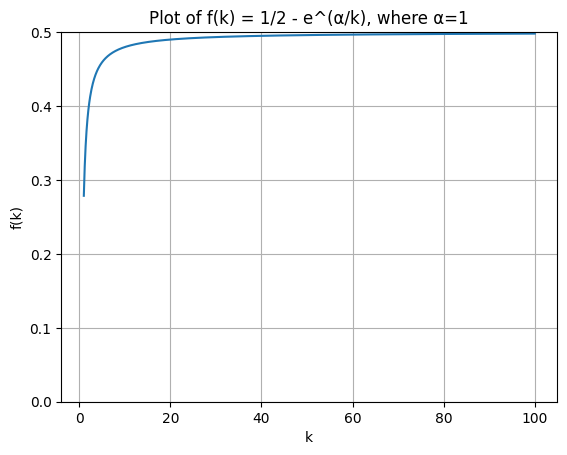

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume alpha = 1 for demonstration purposes
alpha = 0.2

# Define the domain for k (k must be nonzero to avoid division by zero).
k_values = np.linspace(1, 100, 1000)

# Define our function f(k) = 1/2 - e^(alpha / k)
f_values = 1.5 - np.exp(alpha / k_values)

# Create the plot
plt.figure()
plt.ylim(0,0.5)
plt.plot(k_values, f_values)
plt.title("Plot of f(k) = 1/2 - e^(α/k), where α=1")
plt.xlabel("k")

plt.ylabel("f(k)")
plt.grid(True)
plt.show()

In [3]:
import stim
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=1,
    distance=3,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.01)

print(repr(circuit))

stim.Circuit('''
    R 0 1 2 3 4
    TICK
    DEPOLARIZE1(0.04) 0 2 4
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    X_ERROR(0.01) 1 3
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    X_ERROR(0.01) 0 2 4
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')


In [6]:
diagram = circuit.diagram("timeline-svg")
with open('diagram.svg', 'w') as f:
    f.write(str(diagram))

In [46]:
from itertools import combinations

# Step 1: Define the data from the first table
# Format: 'n_index': [D0, D1, O0]
syndrome_data = {
    'n_1': [1, 0, 1],
    'n_2': [1, 1, 0],
    'n_3': [0, 1, 0],
    'n_4': [1, 0, 0],
    'n_5': [0, 1, 0],
    'n_6': [0, 0, 1],
    'n_7': [0, 1, 0]
}

# Step 2: Generate all 2-error combinations and calculate the parity sum
two_error_results = []

for (e1, e2) in combinations(syndrome_data.keys(), 2):
    s1 = syndrome_data[e1]
    s2 = syndrome_data[e2]
    parity_sum = [(s1[i] + s2[i]) % 2 for i in range(3)]
    error_label = f"{e1},{e2}"
    two_error_results.append((error_label, *parity_sum))

index=1
# Step 3: Print the result in LaTeX table row format
for entry in two_error_results:
    err, d0, d1, o0 = entry
    print(f"{index} & ${err}$ & {d0} & {d1} & {o0} &  &  &  No \\\\")
    print("  \\hline")
    index+=1


1 & $n_1,n_2$ & 0 & 1 & 1 &  &  &  No \\
  \hline
2 & $n_1,n_3$ & 1 & 1 & 1 &  &  &  No \\
  \hline
3 & $n_1,n_4$ & 0 & 0 & 1 &  &  &  No \\
  \hline
4 & $n_1,n_5$ & 1 & 1 & 1 &  &  &  No \\
  \hline
5 & $n_1,n_6$ & 1 & 0 & 0 &  &  &  No \\
  \hline
6 & $n_1,n_7$ & 1 & 1 & 1 &  &  &  No \\
  \hline
7 & $n_2,n_3$ & 1 & 0 & 0 &  &  &  No \\
  \hline
8 & $n_2,n_4$ & 0 & 1 & 0 &  &  &  No \\
  \hline
9 & $n_2,n_5$ & 1 & 0 & 0 &  &  &  No \\
  \hline
10 & $n_2,n_6$ & 1 & 1 & 1 &  &  &  No \\
  \hline
11 & $n_2,n_7$ & 1 & 0 & 0 &  &  &  No \\
  \hline
12 & $n_3,n_4$ & 1 & 1 & 0 &  &  &  No \\
  \hline
13 & $n_3,n_5$ & 0 & 0 & 0 &  &  &  No \\
  \hline
14 & $n_3,n_6$ & 0 & 1 & 1 &  &  &  No \\
  \hline
15 & $n_3,n_7$ & 0 & 0 & 0 &  &  &  No \\
  \hline
16 & $n_4,n_5$ & 1 & 1 & 0 &  &  &  No \\
  \hline
17 & $n_4,n_6$ & 1 & 0 & 1 &  &  &  No \\
  \hline
18 & $n_4,n_7$ & 1 & 1 & 0 &  &  &  No \\
  \hline
19 & $n_5,n_6$ & 0 & 1 & 1 &  &  &  No \\
  \hline
20 & $n_5,n_7$ & 0 & 0 & 0 &  &  &  No \

In [36]:
import stim

def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=False)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

circuit=stim.Circuit(
'''
X_ERROR(0.001) 0 1 2 3 4
CX 0 3
CX 1 3
X_ERROR(0.001) 0 1
CX 1 4
CX 2 4
M 3
DETECTOR(1, 0) rec[-1]
M 4
DETECTOR(2, 0) rec[-1]
M 0
OBSERVABLE_INCLUDE(0) rec[-1]
'''
)

import pymatching
import numpy as np
num_shots = 1000_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")
logical_error_rate=num_logical_errors/num_shots

there were 1985 wrong predictions (logical errors) out of 1000000 shots


In [37]:
circuit

stim.Circuit('''
    X_ERROR(0.001) 0 1 2 3 4
    CX 0 3 1 3
    X_ERROR(0.001) 0 1
    CX 1 4 2 4
    M 3
    DETECTOR(1, 0) rec[-1]
    M 4
    DETECTOR(2, 0) rec[-1]
    M 0
    OBSERVABLE_INCLUDE(0) rec[-1]
''')

In [38]:
detector_error_model = circuit.detector_error_model(decompose_errors=False)

In [39]:
detector_error_model

stim.DetectorErrorModel('''
    error(0.001) D0
    error(0.001) D0 D1
    error(0.001) D0 L0
    error(0.002994) D1
    error(0.001) L0
    detector(1, 0) D0
    detector(2, 0) D1
''')

In [40]:
detector_error_model.diagram("matchgraph-svg")

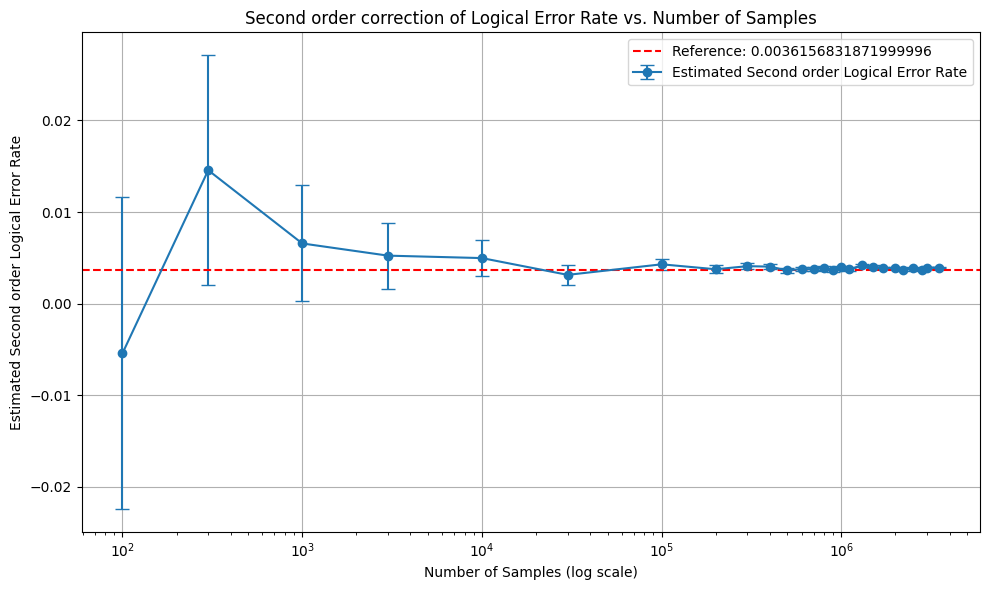

In [125]:
import stim
import pymatching
import numpy as np
import matplotlib.pyplot as plt

def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)
    detector_error_model = circuit.detector_error_model(decompose_errors=False)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)
    predictions = matcher.decode_batch(detection_events)

    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

circuit = stim.Circuit(
'''
X_ERROR(0.02) 0 1 2 3 4
CX 0 3
CX 1 3
X_ERROR(0.02) 0 1
CX 1 4
CX 2 4
M 3
DETECTOR(1, 0) rec[-1]
M 4
DETECTOR(2, 0) rec[-1]
M 0
OBSERVABLE_INCLUDE(0) rec[-1]
'''
)

sample_sizes = [100, 300, 1000, 3000, 10000, 30000, 100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1300000,1500000,1700000,2000000,2200000,2500000,2800000,3000000,3500000]
logical_error_rates = []
std_devs = []
p=0.02
for shots in sample_sizes:
    errors = count_logical_errors(circuit, shots)
    rate = errors / shots
    std = np.sqrt(rate * (1 - rate) / shots)
    logical_error_rates.append(rate-2*p*(1-p)**6)
    std_devs.append(std)

plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, logical_error_rates, yerr=std_devs, fmt='-o', capsize=5, label='Estimated Second order Logical Error Rate')
plt.axhline(y=10*p**2*(1-p)**5, color='red', linestyle='--', linewidth=1.5, label=f'Reference: {10*p**2*(1-p)**5}')

plt.xscale('log')
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Estimated Second order Logical Error Rate")

plt.title("Second order correction of Logical Error Rate vs. Number of Samples")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("second_logical_error_rate.png", dpi=300)  # Save as PNG

In [118]:
circuit = stim.Circuit(
'''
X_ERROR(0.5) 0 1 2 3 4
CX 0 3
CX 1 3
X_ERROR(0.5) 0 1
CX 1 4
CX 2 4
M 3
DETECTOR(1, 0) rec[-1]
M 4
DETECTOR(2, 0) rec[-1]
M 0
OBSERVABLE_INCLUDE(0) rec[-1]
'''
)


sampler = circuit.compile_detector_sampler()
detection_events, observable_flips = sampler.sample(100000000, separate_observables=True)

# Configure a decoder using the circuit.
detector_error_model = circuit.detector_error_model(decompose_errors=False)
matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

# Run the decoder.
predictions = matcher.decode_batch(detection_events)

In [120]:
predictions.sum()

0

In [101]:
# Run the decoder.
detection_events=np.array([[1,0]])
predictions = matcher.decode_batch(detection_events)

In [127]:
from itertools import combinations

# Base 1-error syndrome table (D0, D1, O0)
syndrome_data = {
    'n_1': [1, 0, 1],
    'n_2': [1, 1, 0],
    'n_3': [0, 1, 0],
    'n_4': [1, 0, 0],
    'n_5': [0, 1, 0],
    'n_6': [0, 0, 1],
    'n_7': [0, 1, 0]
}

error_indices = list(syndrome_data.keys())

# Loop over W=3 to W=7
for w in range(2, 8):
    logical_error_count = 0
    total_combinations = 0

    for combo in combinations(error_indices, w):
        total_combinations += 1
        # Compute linear sum modulo 2
        d0, d1, o0 = 0, 0, 0
        for e in combo:
            s = syndrome_data[e]
            d0 = (d0 + s[0]) % 2
            d1 = (d1 + s[1]) % 2
            o0 = (o0 + s[2]) % 2
        if o0 == 1:
            logical_error_count += 1

    print(f"W={w}: Logical errors = {logical_error_count} out of {total_combinations} combinations")


W=2: Logical errors = 10 out of 21 combinations
W=3: Logical errors = 20 out of 35 combinations
W=4: Logical errors = 20 out of 35 combinations
W=5: Logical errors = 10 out of 21 combinations
W=6: Logical errors = 2 out of 7 combinations
W=7: Logical errors = 0 out of 1 combinations


In [1]:
import matplotlib.pyplot as plt
from sympy import symbols, expand, simplify

# Define the symbol
p = symbols('p')

# Define the equation components explicitly
expr = (7*p*(1-p)**6 * 0.29 +
        21*p**2*(1-p)**5 * 0.491 +
        35*p**3*(1-p)**4 * 0.595 +
        35*p**4*(1-p)**3 * 0.581 +
        21*p**5*(1-p)**2 * 0.487 +
        7*p**6*(1-p) * 0.296)

# Expand and simplify the expression
expanded_expr = expand(expr)
simplified_expr = simplify(expanded_expr)

print(f"Simplified polynomial:\n{simplified_expr}")

Simplified polynomial:
p*(0.364000000000004*p**6 - 1.30200000000001*p**5 + 1.512*p**4 - 0.454999999999998*p**3 - 0.280000000000005*p**2 - 1.869*p + 2.03)
